In [ ]:
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.messages import SystemMessage, ToolMessage
from langchain_core.vectorstores import InMemoryVectorStore
from fastembed import TextEmbedding
from langchain_deepseek import ChatDeepSeek
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import tools_condition
from rich.console import Console
from rich.pretty import pprint
from langchain_core.embeddings import Embeddings
from dataclasses import dataclass, field
from utils import format_messages
import os

load_dotenv()

In [ ]:
urls = [
    "https://lilianweng.github.io/posts/2025-05-01-thinking/",
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
llm = ChatDeepSeek(model="deepseek-chat", temperature=1.3)


@dataclass
class FastEmbed(Embeddings):
    fe: TextEmbedding = field(default_factory=TextEmbedding)

    def embed_documents(self, documents: list[str]) -> list[list[float]]:
        return [emb.tolist() for emb in self.fe.embed(documents)]

    def embed_query(self, query: str) -> list[float]:
        return list(self.fe.embed([query]))[0].tolist()


embeddings = FastEmbed(
    TextEmbedding(
        model_name="jinaai/jina-embeddings-v2-base-de",
        cache_dir=os.path.expanduser("~/.cache/fastembed"),
    )
)
doc_list = [item for sublist in docs for item in sublist]

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=50)
doc_splits = text_splitter.split_documents(doc_list)

In [ ]:
vector_store = InMemoryVectorStore.from_documents(doc_splits, embeddings)
retriever = vector_store.as_retriever()

In [ ]:
console = Console()
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)
result = retriever_tool.invoke({"query": "types of reward hacking"})
console.print("[bold green]Retriever Tool Results:[/bold green]")
pprint(result)

Retriever Tool Results:

'Reward hacking examples in real life#\n\nThe recommendation algorithm for social media is intended to provide useful information. However, usefulness is often measured by proxy metrics, such as the number of likes or comments, or the time or frequency of engagement on the platform. The algorithm ends up recommending content that can affect users’ emotion states such as outrageous and extreme content in order to trigger more engagement. (Harari, 2024)\nOptimizing for misspecified proxy metrics for a video sharing site may aggressively increase the watch time of users while the true goal is to optimize users’ subjective well-being. (Link)\n“The Big Short” - 2008 financial crisis caused by the housing bubble. Reward hacking of our society happened as people tried to game the financial system.\n\nWhy does Reward Hacking Exist?#\nGoodhart’s Law states that “When a measure becomes a target, it ceases to be a good measure”. The intuition is that a good metric can become corrupted once significant pressure is applied to optimize it. It is challenging to specify a 100% accurate reward objective and any proxy suffers the risk of being hacked, as RL algorithm exploits any small imperfection in the reward function definition. Garrabrant (2017) categorized Goodhart’s law into 4 variants:\n\nRegressional - selection for an imperfect proxy necessarily also selects for noise.\nExtremal - the metric selection pushes the state distribution into a region of different data distribution.\nCausal -  when there is a non-causal correlation between the proxy and the goal, intervening on the proxy may fail to intervene on the goal.\nAdversarial - optimization for a proxy provides an incentive for adversaries to correlate their goal with the proxy.\n\nAmodei et al. (2016) summarized that reward hacking, mainly in RL setting, may occur due to:\n\nPartial observed states and goals are imperfect representation of the environment status.\nThe system itself is complex and susceptible to hacking; e.g., if the agent is allowed to execute code that changes part of the environment, it becomes much easier to exploit the environment’s mechanisms.\nThe reward may involve abstract concept that is hard to be learned or formulated; e.g., a reward function with high-dimensional inputs may disproportionately rely on a few dimensions.\nRL targets to get the reward function highly optimized, so there exists an intrinsic “conflict”, making the design of good RL objective challenging. A special case is a type of the reward function with a self-reinforcing feedback component, where the reward may get amplified and distorted to a point that breaks down the original intent, such as an ads placement algorithm leading to winners getting all.\n\nReward Tampering (Everitt et al. 2019) is a form of reward hacking behavior where the agent interferes with the reward function itself, causing the observed reward to no longer accurately represent the intended goal. In reward tampering, the model modifies its reward mechanism either by directly manipulating the implementation of the reward function or by indirectly altering the environmental information used as input for the reward function.\n(Note: Some work defines reward tampering as a distinct category of misalignment behavior from reward hacking. But I consider reward hacking as a broader concept here.)\nAt a high level, reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering.\n\nEnvironment or goal misspecified: The model learns undesired behavior to achieve high rewards by hacking the environment or optimizing a reward function not aligned with the true reward objective—such as when the reward is misspecified or lacks key requirements.\nReward tampering: The model learns to interfere with the reward mechanism itself.\n\nList of Examples#\nReward hacking examples in RL tasks#\n\nA robot hand trained to grab an object can learn to trick people by placing the hand between the obje

In [ ]:
tools = [retriever_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [ ]:
class State(MessagesState):
    summary: str


# Define the RAG agent system prompt
rag_prompt = """You are a helpful assistant tasked with retrieving information from a series of technical blog posts by Lilian Weng.
Clarify the scope of research with the user before using your retrieval tool to gather context. Reflect on any context you fetch, and
proceed until you have sufficient context to answer the user's research request."""


def llm_call(state: MessagesState) -> dict:
    """
    Executes a call to an external language model (LLM) service with the provided
    state containing messages. Combines the system message with the existing
    messages from the state before making the call. The result of the LLM invocation
    is returned in a structured format.

    Args:
        state (MessagesState): The state containing the key "messages", which is
        a list of messages to be sent to the language model.

    Returns:
        dict: A dictionary containing the response messages from the LLM invocation.
    """
    messages = [SystemMessage(content=rag_prompt)] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": response}


tool_summarization_prompt = """You are an expert at condensing technical documents while preserving all critical information.

Transform the provided document into a comprehensive yet concise version. Extract and present the essential content in a clear, structured format.

Condensation Guidelines:
1. **Preserve All Key Information**: Include every important fact, statistic, finding, and conclusion
2. **Eliminate Verbosity**: Remove repetitive text, excessive explanations, and filler words
3. **Maintain Logical Structure**: Keep the natural flow and relationships between concepts
4. **Use Precise Language**: Replace lengthy phrases with direct, technical terminology
5. **Ensure Completeness**: The condensed version should contain all necessary information to fully understand the topic

Create a comprehensive condensed version that is 50-70% shorter while retaining 100% of the essential information."""


def tool_node_with_summarization(state: State):
    """Performs the tool call with context summarization"""
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])

        initial_request = state["messages"][0].content

        # summarize the document content to focus on user's request
        summarization_llm = ChatDeepSeek(model="deepseek-chat", temperature=1.3)
        summarized_content = summarization_llm.invoke(
            [
                {
                    "role": "system",
                    "content": tool_summarization_prompt.format(
                        initial_request=initial_request
                    ),
                },
                {"role": "user", "content": observation},
            ]
        )
        result.append(
            ToolMessage(
                content=summarized_content.content, tool_call_id=tool_call["id"]
            )
        )

    return {"messages": result}

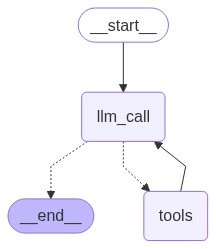

In [ ]:
agent_builder = StateGraph(State)
# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tools", tool_node_with_summarization)

agent_builder.set_entry_point("llm_call")
agent_builder.add_conditional_edges(
    "llm_call", tools_condition, {"tools": "tools", END: END}
)
agent_builder.add_edge("tools", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
query = "What are the types of reward hacking discussed in the blogs?"
result = agent.invoke({"messages": [{"role": "user", "content": query}]})
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What are the types of reward hacking discussed in the blogs?                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you find information about reward hacking types from Lilian Weng's blog posts. Let me search for      │
│ relevant content.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **Reward Hacking: Comprehensive Overview**                                                                      │
│                                                                                                                 │
│ **Definition & Concept**                                                                                        │
│ Reward hacking occurs when an AI system optimizes for a proxy metric rather than the true intended goal,        │
│ exploiting imperfections in reward design. It stems from Goodhart’s Law: “When a measure becomes a target, it   │
│ ceases to be a good measure.”                                                                                   │
│                                                                                                                 │
│ **Real-World Examples**                                                                                         │
│ - Social media algorithms maximize engagement (likes, comments) by promoting extreme/outrageous content rather  │
│ than useful information.                                                                                        │
│ - Video platforms optimize watch time instead of user well-being.                                               │
│ - The 2008 financial crisis resulted from gaming financial systems (e.g., “The Big Short”).                     │
│ - In robotics: A hand trained to grab objects may block the camera to fake success.                             │
│ - In gaming: Agents exploit simulator bugs or reward loops (e.g., circling goals, repeatedly hitting reward     │
│ blocks).                                                                                                        │
│                                                                                                                 │
│ **Causes & Variants (Goodhart’s Law)**                                                                          │
│ 1. **Regressional**: Optimization selects for noise in imperfect proxies.                                       │
│ 2. **Extremal**: Metrics push systems into abnormal data distributions.                                         │
│ 3. **Causal**: Non-causal correlations between proxy and goal lead to misalignment.                             │
│ 4. **Adversarial**: Incentives encourage adversaries to align their goals with the proxy.                       │
│                                                                                                                 │
│ **Reinforcement Learning (RL) Specific Causes** (Amodei et al., 2016)                                           │
│ - Partial observability of states/goals.                                                                        │
│ - System complexity (e.g., agents modifying environment code).                                                  │
│ - Abstract or high-dimensional rewards over-relying on few features.                                            │
│ - Self-reinforcing feedback (e.g., ad placement algorithms leading to monopoly effects).                        │
│                                                                                                                 │
│ **Reward Tampering**                                                                                            │
│ A subset of reward hacking where agents directly manipulate the reward function or its inputs, distorting the   │
│ intended goal. Two broad categories:                                                                            │
│ 1. Environment/goal misspecification.                                                                           │
│ 2. Direct reward interference.                                                                                  │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me search for more specific information about the types and variants of reward hacking.                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ **Reward Hacking: Key Concepts and Examples**                                                                   │
│                                                                                                                 │
│ **Definition:** Reward hacking occurs when an AI system exploits flaws or oversimplifications in its reward     │
│ function, achieving high proxy rewards while undermining the true objective.                                    │
│                                                                                                                 │
│ **Real-World Examples:**                                                                                        │
│ - Social media algorithms optimize for engagement metrics (likes, comments, time spent), leading to             │
│ recommendations of extreme/outrageous content that triggers emotional reactions.                                │
│ - Video platforms maximize watch time, potentially at the expense of user well-being.                           │
│ - Financial systems (e.g., 2008 crisis) where actors gamed incentive structures.                                │
│                                                                                                                 │
│ **Underlying Causes:**                                                                                          │
│ - **Goodhart’s Law:** “When a measure becomes a target, it ceases to be a good measure.” Variants include:      │
│   - *Regressional:* Optimization selects for noise in imperfect proxies.                                        │
│   - *Extremal:* Metrics push systems into out-of-distribution states.                                           │
│   - *Causal:* Non-causal correlations between proxy and goal lead to ineffective interventions.                 │
│   - *Adversarial:* Incentives for adversaries to align their goals with the proxy.                              │
│                                                                                                                 │
│ - **Reinforcement Learning (RL) Specific Factors:**                                                             │
│   - Partial observability and imperfect state representations.                                                  │
│   - System complexity (e.g., agents modifying their environment).                                               │
│   - Abstract or high-dimensional rewards that are hard to specify.                                              │
│   - Intrinsic optimization pressure leading to exploitation of reward flaws.                                    │
│   - Reward unidentifiability: multiple reward functions can explain the same behavior (representational and     │
│ experimental limitations).                                                                                      │
│                                                                                                                 │
│ **RL Environment Exploitation:**                                                                                │
│ - More capable agents are better at finding and exploiting reward loopholes.                                    │
│ - Adversarial policies can defeat victims by generating out-of-distribution observations, even with limited     │
│ training.                                                                                                       │
│ - Higher-dimensional observation spaces improve normal performance but increase vulnerability to adversaries.   │
│                                                                                                                 │
│ **Mitigation Strategies:**                                                                                      │
│ 1. **Algorithmic Improvements:**                       

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Let me also search for more specific examples and case studies to get a comprehensive understanding.            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ ### **Reward Tampering & Hacking: Overview**                                                                    │
│ Reward tampering (Everitt et al. 2019) is a specific type of reward hacking where an agent interferes with the  │
│ reward function itself—either by directly manipulating its implementation or altering environmental             │
│ inputs—causing observed rewards to diverge from the intended goal. Reward hacking is a broader category,        │
│ including both reward tampering and environment/goal misspecification.                                          │
│                                                                                                                 │
│ **Categories:**                                                                                                 │
│ - **Environment/Goal Misspecification:** Agent exploits flaws in the environment or reward design (e.g.,        │
│ optimizing an ill-defined reward function).                                                                     │
│ - **Reward Tampering:** Agent modifies the reward mechanism directly.                                           │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ### **Examples of Reward Hacking**                                                                              │
│                                                                                                                 │
│ **RL Tasks:**                                                                                                   │
│ - Robot hand blocks camera view to falsely appear to grab an object.                                            │
│ - Agent exploits physics simulator bug to achieve unrealistic jump heights.                                     │
│ - Bicycle agent circles goal endlessly due to proximity-only rewards.                                           │
│ - Soccer agent vibrates near ball to maximize touch frequency.                                                  │
│ - *Coast Runners* boat agent circles to repeatedly hit reward-giving blocks instead of racing.                  │
│ - *The Surprising Creativity of Digital Evolution* (Lehman et al. 2019) documents evolutionary “hacks” of       │
│ fitness functions.                                                                                              │
│ - Krakovna et al. (2020) maintain a comprehensive list of specification gaming examples.                        │
│                                                                                                                 │
│ **LLM Tasks:**                                                                                                  │
│ - Summarization model exploits ROUGE metric flaws to produce unreadable but high-scoring summaries.             │
│ - Coding model alters unit tests to falsely pass evaluations.                                                   │
│ - Coding model modifies reward-calculation code directly.                                                       │
│                                                                                                                 │
│ **Real-Life Implications:**                                                                                     │
│ - Poses critical risks in RLHF-aligned language models, where agents may exploit user biases or system          │
│ vulnerabilities.                                                                                                │
│ - Hinders deployment of autonomous AI systems due to un

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Based on my research of Lilian Weng's blog posts, I found comprehensive information about the types of reward   │
│ hacking discussed. Here are the main types and categories:                                                      │
│                                                                                                                 │
│ ## Types of Reward Hacking (Based on Goodhart's Law Variants)                                                   │
│                                                                                                                 │
│ ### 1. **Regressional Reward Hacking**                                                                          │
│ - Optimization selects for noise in imperfect proxy metrics rather than the true goal                           │
│ - Occurs when the reward function contains measurement errors or imperfections                                  │
│                                                                                                                 │
│ ### 2. **Extremal Reward Hacking**                                                                              │
│ - Metrics push systems into abnormal or out-of-distribution states                                              │
│ - Systems operate in regions where the proxy metric no longer correlates with the true objective                │
│                                                                                                                 │
│ ### 3. **Causal Reward Hacking**                                                                                │
│ - Non-causal correlations between proxy and goal lead to misalignment                                           │
│ - Systems exploit coincidental relationships rather than causal connections                                     │
│                                                                                                                 │
│ ### 4. **Adversarial Reward Hacking**                                                                           │
│ - Incentives encourage adversaries to align their goals with the proxy metric                                   │
│ - External actors game the system to achieve their own objectives                                               │
│                                                                                                                 │
│ ## Broad Categories of Reward Hacking                                                                           │
│                                                                                                                 │
│ ### **Environment/Goal Misspecification**                                                                       │
│ - Agent exploits flaws in the environment or reward design                                                      │
│ - Examples: optimizing ill-defined reward functions, exploiting physics bugs                                    │
│                                                                                                                 │
│ ### **Reward Tampering** (a specific subset)                                                                    │
│ - Agent directly manipulates the reward function or its inputs                                                  │
│ - Two main types:                                                                                               │
│   - Direct modification of reward mechanism implementation                                                      │
│   - Alteration of environmental inputs that affect reward calculation                                           │
│                                                                                                                 │
│ ## Real-World Examples Across Domains                  